In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [3]:
%run utils.py

In [4]:
%run models.py

In [5]:
%%time

image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
CPU times: user 23.2 s, sys: 2.52 s, total: 25.8 sing 88/117Interpolating 1/112Interpolating 59/112Interpolating 88/112Interpolating 1/111Interpolating 59/111Interpolating 1/109Interpolating 61/109Interpolating 1/113Interpolating 62/113Interpolating 1/104Interpolating 56/104Interpolating 91/104Interpolating 1/101Interpolating 55/101Interpolating 86/101Interpolating 1/102Interpolating 61/102Interpolating 1/107Interpolating 61/107Interpolating 107/107Interpolating 1/113Interpolating 61/113Interpolating 105/113Interpolating 1/115Interpolating 60/115Interpolating 1/139Interpolating 61/139Interpolating 114/139Interpolating 1/123Interpolating 49/123Interpolating 75/123Interpolating 103/123Interpolating 1/118Interpolating 48/118Interpolating 79/118Interpolating 1/120Interpolating 57/120Interpolating 106/120Interpolating 1/117Interpolating 61/117Interpolating 115/117
Wall time: 26 s


In [6]:
X.shape, y.shape

((1821, 28, 28, 3), (1821,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


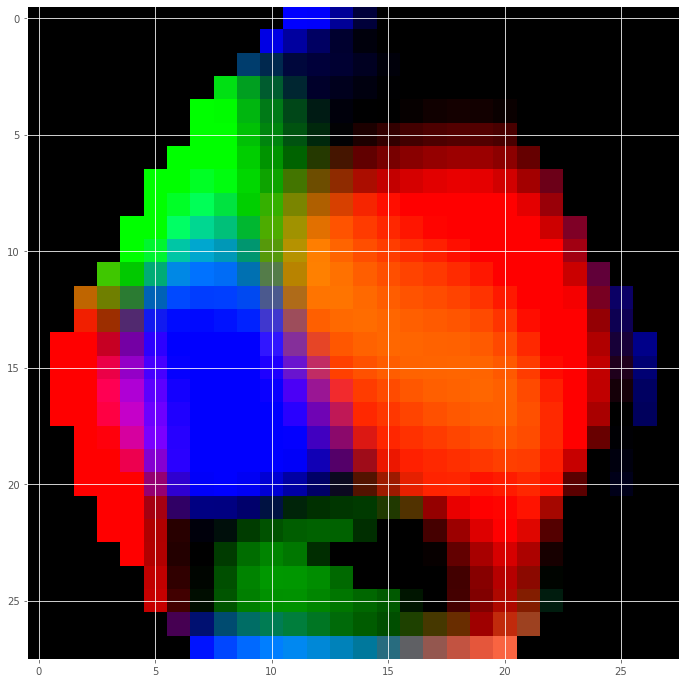

In [7]:
plt.imshow(X[3])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [9]:
y_train.shape

(1456,)

In [10]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (1456, 28, 28, 3)
1456 train samples
365 test samples


In [11]:
np.mean(x_train)

0.0024639356

### Train Original Model

In [12]:
batch_size = 32
num_classes = 2
epochs = 200

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)


model = get_func_model_1(input_shape, num_classes)
# model = get_model_2(input_shape, num_classes)


# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255


history = model.fit(x_train, y_train_cat,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test_cat),
          shuffle=True, verbose=0)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                62730     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total para

In [14]:
model.layers

### Transfer Learning to CAM model

In [15]:
from keras.layers import GlobalAveragePooling2D

base_model = model.layers[-4].output
global_pool = GlobalAveragePooling2D()(base_model)
out_layer = Dense(num_classes, activation='softmax')(global_pool)
cam_model = Model(inputs=model.input, outputs=out_layer)


In [16]:
for layer in cam_model.layers[:4]:
    layer.trainable=False

In [17]:
epochs = 100

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
cam_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = cam_model.fit(x_train, y_train_cat,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test_cat),
          shuffle=True, verbose=1)

Train on 1456 samples, validate on 365 samples
Epoch 1/100
1456/1456 [==============================] - 3s 2ms/step - loss: 0.7049 - acc: 0.5000 - val_loss: 0.7021 - val_acc: 0.4959
Epoch 2/100
1456/1456 [==============================] - 1s 798us/step - loss: 0.7040 - acc: 0.5021 - val_loss: 0.7012 - val_acc: 0.4959
Epoch 3/100
1456/1456 [==============================] - 1s 860us/step - loss: 0.7032 - acc: 0.5007 - val_loss: 0.7005 - val_acc: 0.4986
Epoch 4/100
1456/1456 [==============================] - 1s 794us/step - loss: 0.7024 - acc: 0.5007 - val_loss: 0.6998 - val_acc: 0.4986
Epoch 5/100
1456/1456 [==============================] - 1s 807us/step - loss: 0.7018 - acc: 0.5027 - val_loss: 0.6990 - val_acc: 0.4904
Epoch 6/100
1456/1456 [==============================] - 1s 851us/step - loss: 0.7011 - acc: 0.5027 - val_loss: 0.6983 - val_acc: 0.4932
Epoch 7/100
1456/1456 [==============================] - 1s 833us/step - loss: 0.7005 - acc: 0.5048 - val_loss: 0.6977 - val_acc: 0.4

1456/1456 [==============================] - 1s 638us/step - loss: 0.6921 - acc: 0.5179 - val_loss: 0.6908 - val_acc: 0.5315
Epoch 61/100
1456/1456 [==============================] - 1s 645us/step - loss: 0.6921 - acc: 0.5192 - val_loss: 0.6908 - val_acc: 0.5342
Epoch 62/100
1456/1456 [==============================] - 1s 634us/step - loss: 0.6920 - acc: 0.5206 - val_loss: 0.6908 - val_acc: 0.5342
Epoch 63/100
1456/1456 [==============================] - 1s 642us/step - loss: 0.6920 - acc: 0.5192 - val_loss: 0.6908 - val_acc: 0.5315
Epoch 64/100
1456/1456 [==============================] - 1s 641us/step - loss: 0.6919 - acc: 0.5179 - val_loss: 0.6908 - val_acc: 0.5315
Epoch 65/100
1456/1456 [==============================] - 1s 631us/step - loss: 0.6919 - acc: 0.5165 - val_loss: 0.6909 - val_acc: 0.5233
Epoch 66/100
1456/1456 [==============================] - 1s 632us/step - loss: 0.6918 - acc: 0.5192 - val_loss: 0.6908 - val_acc: 0.5260
Epoch 67/100
1456/1456 [=======================

In [18]:
cam_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 10,210
Trainable params: 66
Non-trainable params: 10,144
_________________________________________________________________


In [19]:
cam_model_static = Model(inputs=cam_model.input, outputs=[cam_model.output, cam_model.layers[-4].output])
for layer in cam_model_static.layers:
    layer.trainable = False
cam_model_static.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [20]:
imgs = X
class_weights = cam_model_static.layers[-1].get_weights()[0]
[predictions, conv_outputs_batch] = cam_model_static.predict(imgs)


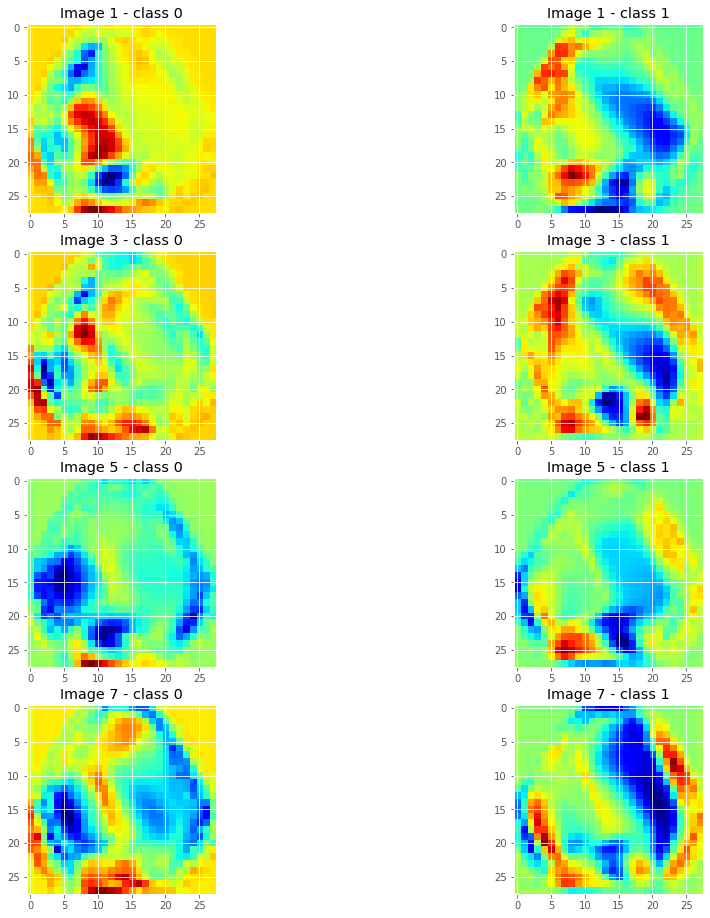

In [28]:

def get_cam(target, target_class=0):
    conv_outputs = conv_outputs_batch[target, :, :, :]
    #Create the class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, target_class]):
        cam += w * conv_outputs[:, :, i]
    return cam
    
    
fig= plt.figure(figsize=(16, 16))
columns = 2
rows = 4
offset = 
for i in range(1, 8 + 1, 2):
    cam1 = get_cam(i, target_class=0)
    fig.add_subplot(rows, columns, i)
    plt.imshow(cam1, cmap='jet')
    plt.title(f'Image {i} - class {0}')
    cam2 = get_cam(i, target_class=1)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(cam2, cmap='jet')
    plt.title(f'Image {i} - class {1}')
    
plt.show()